In [ ]:
#pip install h5py

In [ ]:
#pip install opencv-python

In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

/tmp/ipykernel_1037855/680206115.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
 root = '/home/idisc02/Documents/palm_tree_dummy/'

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import h5py
import glob
import os
import scipy.spatial

def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 30
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1], pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1
        else:
            sigma = np.average(np.array(gt.shape)) / 2. / 2.  # case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

root = '/home/idisc02/Documents/palm_tree_dummy/'

# Specify the paths
part_A_train = os.path.join(root, 'part_A/train_data', 'images')
part_A_test = os.path.join(root, 'part_A/test_data', 'images')

path_sets = [part_A_train, part_A_test]

for path in path_sets:
    img_paths = glob.glob(os.path.join(path, '*.png'))

    for img_path in img_paths:
        print(img_path)
        json_path = img_path.replace('.png', '.json').replace('images', 'ground_truth').replace('IMG_', 'image_')

        with open(json_path, 'r') as file:
            data = json.load(file)

        gt = data['tree']
        img = plt.imread(img_path)
        k = np.zeros((img.shape[0], img.shape[1]))

        for point in gt:
            x, y = point
            if int(y) < img.shape[0] and int(x) < img.shape[1]:
                k[int(y), int(x)] = 1

        k = gaussian_filter_density(k)  # Generate density map

        h5_path = img_path.replace('.png', '.h5').replace('images', 'ground_truth')
        with h5py.File(h5_path, 'w') as hf:
            hf.create_dataset('density', data=k)


/home/idisc02/Documents/palm_tree_dummy/part_A/train_data/images/image1.png
(1024, 1024)
generate density...


/tmp/ipykernel_1037855/1137038221.py:32: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')


done.
/home/idisc02/Documents/palm_tree_dummy/part_A/train_data/images/image3.png
(1024, 1024)
generate density...
done.
/home/idisc02/Documents/palm_tree_dummy/part_A/train_data/images/image2.png
(1024, 1024)
generate density...
done.
/home/idisc02/Documents/palm_tree_dummy/part_A/test_data/images/image4.png
(1024, 1024)
generate density...
done.
/home/idisc02/Documents/palm_tree_dummy/part_A/test_data/images/image5.png
(1024, 1024)
generate density...
done.


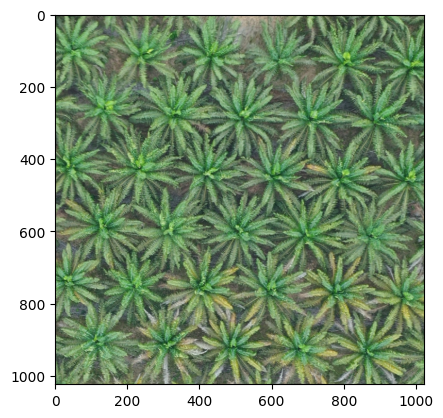

In [6]:
#now see a sample from part_A
plt.imshow(Image.open(img_paths[1]))

/tmp/ipykernel_1037855/689005281.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  groundtruth = np.asarray(gt_file['density'])


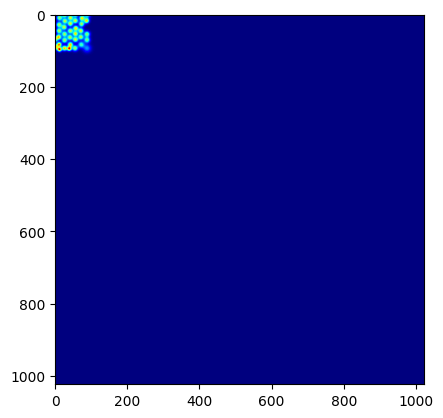

In [7]:
gt_file = h5py.File(img_paths[1].replace('.png','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [8]:
np.sum(groundtruth)# don't mind this slight variation

34.02258